In [ ]:
#Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.arima.model as stats
from statsmodels.tsa.arima_model import ARIMA

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [ ]:
#Data Importation
pl11 = pd.read_csv('PL11_data_all_En.csv')
pl11.head()

,Cycles,Capacity,PerEn3
0,6,1.4393,1.8572
1,11,1.4360,1.8107
2,16,1.4335,1.7562
3,21,1.4314,1.7692
4,26,1.4282,1.8305


In [ ]:
df = pd.DataFrame({'Capacity':None,'PerEn':None,'Cycles':np.arange(1,703)})
for i in range(132):
  df['Capacity'][pl11.iloc[i][0]] = pl11['Capacity'][i]
  df['PerEn'][pl11.iloc[i][0]] = pl11['PerEn3'][i]
df['Capacity'][701] = pl11['Capacity'][132]
df['PerEn'][701] = pl11['PerEn3'][132]

for i in range(132):
  if (df['Capacity'][i]!=None):
      df['Capacity'][0] = df['Capacity'][i]
      df['PerEn'][0] = df['PerEn'][i]
      break

for i in range(702):
  if (df['Capacity'][i]==None):
    j = i+1
    while j<=702:
      if (df['Capacity'][j]!=None):
        break
      j+=1
    df['Capacity'][i] = np.mean([df['Capacity'][i-1],df['Capacity'][j]])
    df['PerEn'][i] = np.mean([df['PerEn'][i-1],df['PerEn'][j]])
df['PerEn'] = pd.to_numeric(df['PerEn'])
df['Capacity'] = pd.to_numeric(df['Capacity'])

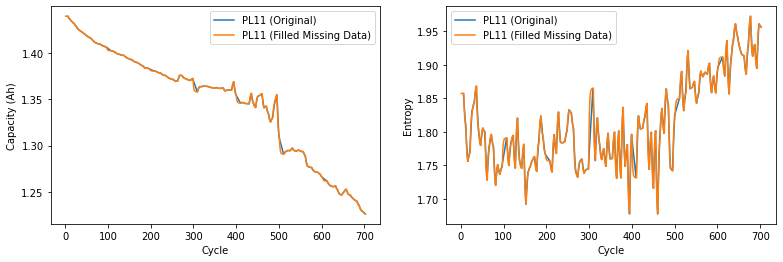

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (13,4))
ax[0].plot(pl11['Cycles'], pl11['Capacity'],label='PL11 (Original)')
ax[0].plot(df['Cycles'], df['Capacity'],label='PL11 (Filled Missing Data)')
ax[0].set_xlabel('Cycle')
ax[0].set_ylabel('Capacity (Ah)')
ax[0].legend()
ax[1].plot(pl11['Cycles'], pl11['PerEn3'],label='PL11 (Original)')
ax[1].plot(df['Cycles'], df['PerEn'],label='PL11 (Filled Missing Data)')
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Entropy')
ax[1].legend()

#Arima

In [ ]:
x = df['PerEn']
y = df['Capacity']
y = np.array([y]).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 42, shuffle=False)

data = df['Capacity'].values
train, test = data[0:len(X_train)], data[len(X_train):len(x)]
data = [x for x in train]

In [ ]:
y_pred_ARIMA = list()
for t in range(len(test)):
	model = stats.ARIMA(data, order=(5,1,0))
	model_fit = model.fit()
	out = model_fit.forecast()
	pred = out[0]
	y_pred_ARIMA.append(pred)
	obs = test[t]
	data.append(obs)
	print('predicted=%f, expected=%f' % (pred, obs))

#LSTM

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(1, return_sequences=False, input_shape= (len(X_train), 1)))
#model.add(LSTM(1, return_sequences=False))
#model.add(tf.keras.layers.Dense(units=3,activation='relu'))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=2000, validation_data=(X_test, y_test))

In [ ]:
y_pred_LSTM = model.predict(X_test+0.1)
np.concatenate((y_pred_LSTM.reshape(len(X_test),1),y_test.reshape(len(X_test),1)),1)

#Evaluation

In [ ]:
pred_LSTM = pd.DataFrame(y_pred_LSTM,index = df[len(X_train):].index,columns=['Prediction'])
pred_ARIMA = pd.DataFrame(y_pred_ARIMA,index = df[len(X_train):].index,columns=['Prediction'])

plt.figure(figsize=(12,6))
plt.plot(df[:len(X_train)]['Capacity'],label='Train Data')
plt.plot(df[len(X_train):]['Capacity'],color='green',label='Test Data')
plt.plot(pred_LSTM,color='red', label='LSTM')
plt.plot(pred_ARIMA, color='orange', label='ARIMA')

plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.show()

In [ ]:
print('LSTM')
print(' ')
print('MAE : ' , metrics.mean_absolute_error(y_test,y_pred_LSTM))
print('MSE : ' , metrics.mean_squared_error(y_test,y_pred_LSTM))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(y_test,y_pred_LSTM)))

LSTM
 
MAE :  0.009782862467136022
MSE :  0.00015402293216465061
RMSE :  0.012410597574841052


In [ ]:
print('ARIMA')
print(' ')
print('MAE : ' , metrics.mean_absolute_error(test,y_pred_ARIMA))
print('MSE : ' , metrics.mean_squared_error(test,y_pred_ARIMA))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(test,y_pred_ARIMA)))

ARIMA
 
MAE :  0.0002658184653835613
MSE :  4.317185823710474e-07
RMSE :  0.0006570529524863634
